# **Install libary**

In [ ]:
!pip install tensorflow==2.9.*

In [ ]:

!pip install scikit-learn==1.3.0
!pip install keras==2.6

**Upload and Unzip dataset**

In [ ]:
from IPython.lib.display import exists
#Unzip file
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_file_path = '/content/drive/My Drive/face_mini.zip'
extraction_path = '/content/face_mini'

os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Array, image processing
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Model Operation
from keras import Model, Input
import keras.utils as image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
# io
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

In [ ]:
# Define the path to the folder containing your image files
folder_path = '../content/face_mini/'

# Define the file pattern for the images you want to read (e.g., *.jpg)
file_pattern = '**/*.jpg'

# Use glob.glob to find all image files that match the pattern within the specified folder and its subdirectories
image_files = glob.glob(f'{folder_path}{file_pattern}', recursive=True)

# Initialize a list to store NumPy arrays of the images
images = []

# Loop through the image files, read them, and convert them to NumPy arrays
for file_path in image_files:
    # Read the image file using OpenCV
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)

    # Resize the image to (100, 100)
    img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_NEAREST)

    # Append the image to the list
    images.append(img)

# Convert the list to a NumPy array
images_array = np.array(images)

# Normalize the images
images_array = images_array / 255.0

# Split the data into training, validation, and testing sets
train_x, test_x = train_test_split(images_array, test_size=0.3, random_state=42)
train_x, val_x = train_test_split(train_x, test_size=0.2, random_state=42)

# Define noise parameters
noise_mean = 0
noise_std = 0.5
noise_factor = 0.2

# Create noise and add it to the images
train_x_noise = train_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=train_x.shape))
val_x_noise = val_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=val_x.shape))
test_x_noise = test_x + (noise_factor * np.random.normal(loc=noise_mean, scale=noise_std, size=test_x.shape))


# **Show Noise Image**

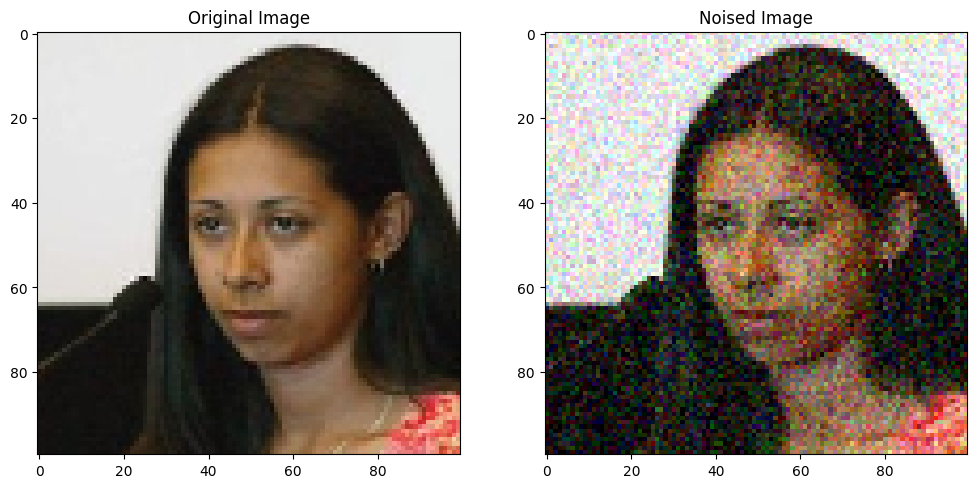

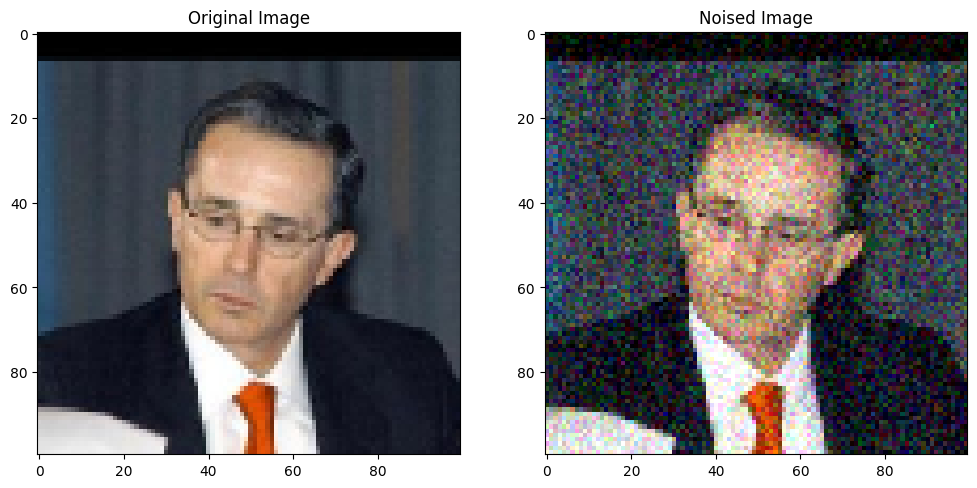

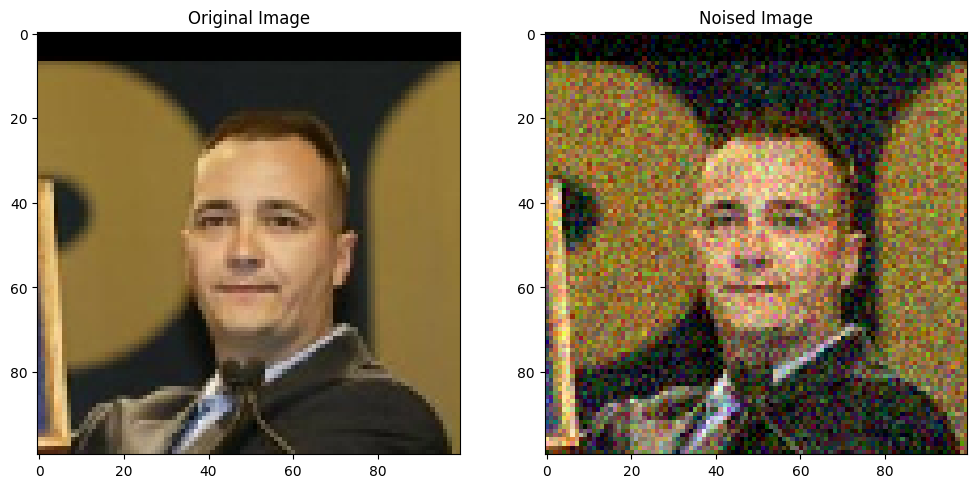

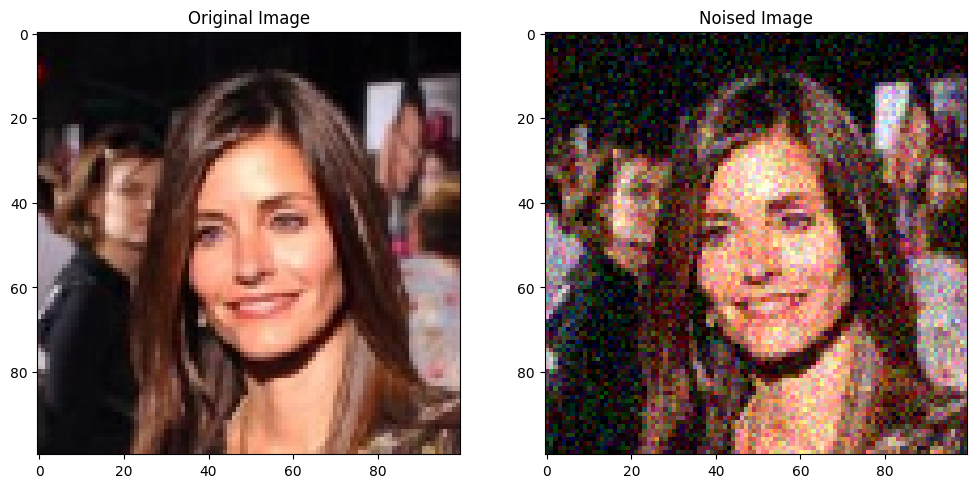

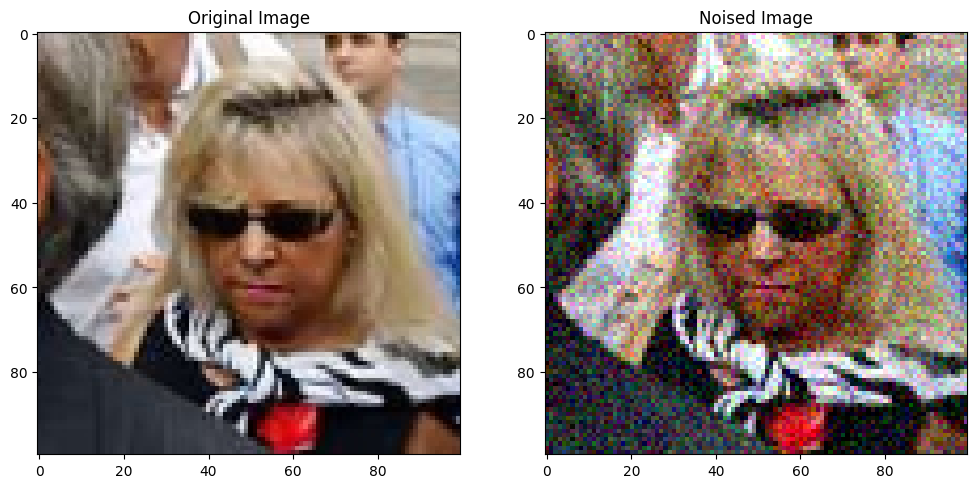

In [ ]:
for i in range(0, 5):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(train_x[i])

    # Denoised Image
    plt.subplot(1, 2, 2)
    plt.title("Noised Image")
    plt.imshow(train_x_noise[i])

    plt.show()

**Create Model**
*Not complate*

In [ ]:
def create_model(optimizer='adam', learning_rate=0.001, batch_size=16, epochs=20):
    # Variable input Image
    input_img = Input(shape=(100, 100, 3))
    print(input_img.shape)

    # Encoding
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D((2, 2), strides=2)(x2)
    x3 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)

    # Decoding
    x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x5 = Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
    x5 = UpSampling2D((2, 2))(x5)
    x6 = Conv2D(128, (3, 3), activation='relu', padding='same')(x5)
    x7 = Conv2D(256, (3, 3), activation='relu', padding='same')(x6)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x7)

    # Construct the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    autoencoder.summary()
    return autoencoder


# **4.2**

Train Model

In [ ]:
e = [2,4,6,8,16]
b = [16,32,64,128]
autoencoder = create_model()

callback = EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(train_x_noise, train_x,
   epochs=16,
   batch_size=32,
   shuffle=True,
   validation_data=(val_x_noise, val_x),
   callbacks=[callback],verbose=1)

Plot Graph


In [ ]:
predictions_test = autoencoder.predict(test_x_noise)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
num_of_plot = 5

for i in range(num_of_plot):
    #Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_x[i])

    #Noise Image
    plt.subplot(1,3,2)
    plt.title("Noise Image")
    plt.imshow(test_x_noise[i])

    #Denoise Image
    plt.subplot(1, 3, 3)
    plt.title("Denoise Image")
    plt.imshow(predictions_test[i])

    plt.show()

# **4.3**

In [ ]:
opts = ['adam', 'sgd']
lnR = [0.001, 0.01, 0.1]
bs = [16, 32]
eps = [10, 50]

param_grid = dict(optimizer=opts, learning_rate=lnR, batch_size=bs, epochs=eps)

# Step 8: Create the KerasRegressor model
model = KerasRegressor(build_fn=create_model, verbose=0)

# Step 9: Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=2, verbose=10)

# Step 10: Fit the grid search to your data
grid_result = grid.fit(train_x_noise, train_x)

# Step 11: Print the best parameters and score
print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)

# Step 12: Get the mean and standard deviation of the scores for each parameter set
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"Mean: {mean}, Std: {std}, Params: {param}")

# Step 13: Train the autoencoder with the best hyperparameters
best_params = grid_result.best_params_
autoencoder = create_model(**best_params)
predictions_test = autoencoder.fit(train_x_noise, train_x, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                          shuffle=True, validation_data=(val_x_noise, val_x), verbose=1)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2; 1/24] START batch_size=16, epochs=10, learning_rate=0.001, optimizer=adam
(None, 100, 100, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 100, 100, 256)     7168      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 100, 100, 128)     295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_99 (Conv2D)           

In [ ]:
best_params = grid_result.best_params_
autoencoder = create_model(**best_params)
history = autoencoder.fit(train_x_noise, train_x, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                          shuffle=True, validation_data=(val_x_noise, val_x), verbose=1)

(None, 100, 100, 3)
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_99 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_546 (Conv2D)          (None, 100, 100, 256)     7168      
_________________________________________________________________
conv2d_547 (Conv2D)          (None, 100, 100, 128)     295040    
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_548 (Conv2D)          (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_549 (Conv2D)          (None, 50, 50, 64)        73792     
_________________________________________________________________
conv2d_550 (Conv2D)          (None, 50

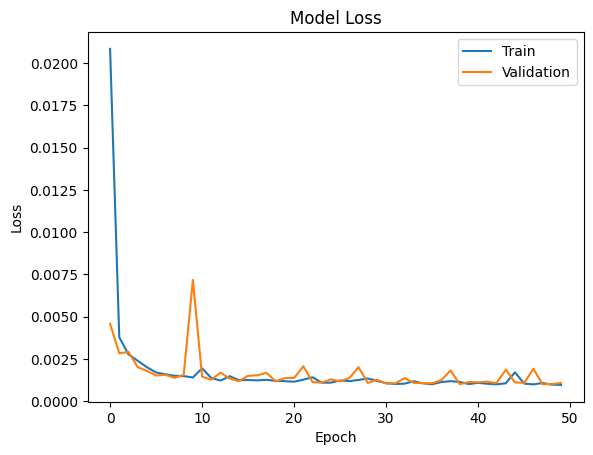

In [ ]:
predictions_test = autoencoder.predict(test_x_noise)
# Plot the loss curves using the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

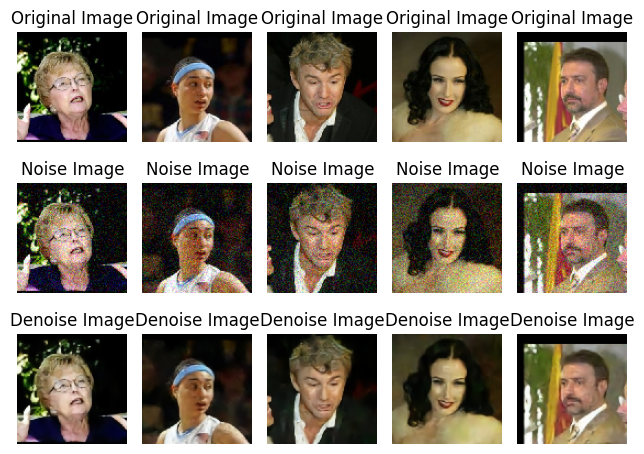

In [ ]:
num_of_plot = 5

for i in range(num_of_plot):
    # Original Image
    plt.subplot(3, num_of_plot, i + 1)  # Adjust the subplot indices
    plt.title("Original Image")
    plt.imshow(test_x[i])
    plt.axis('off')

    # Noise Image
    plt.subplot(3, num_of_plot, num_of_plot + i + 1)  # Adjust the subplot indices
    plt.title("Noise Image")
    plt.imshow(test_x_noise[i])
    plt.axis('off')

    # Denoise Image (Assuming you have 'predictions' as denoised images)
    plt.subplot(3, num_of_plot, 2 * num_of_plot + i + 1)  # Adjust the subplot indices
    plt.title("Denoise Image")
    plt.imshow(predictions_test[i])
    plt.axis('off')

plt.tight_layout()
plt.show()